This is an Example notebook. We are training on Iris dataset using our package NNSOM


Lets import NNSOM package

In [26]:
!pip install --upgrade NNSOM


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [27]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from numpy.random import default_rng
from NNSOM import SOM
from sklearn.datasets import load_iris
from NNSOM.som import preminmax

In [28]:

# Load the Iris dataset
iris = load_iris()

# Create DataFrame
data = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

# Map target values to label names
label_names = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
data['target'] = data['target'].map(label_names)

# Separate features and target
X = data[data.columns[:-1]]
y = data['target']

# Normalize the data using preminmax
normalized_data, min_values, max_values = preminmax(X)
df = pd.DataFrame(normalized_data, columns=iris.feature_names)

# Example: Print the first few rows of the normalized data
print(df.head())


df = np.transpose(df)


   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                1.0          0.346939          -0.510204              -1.0
1                1.0          0.191489          -0.489362              -1.0
2                1.0          0.333333          -0.511111              -1.0
3                1.0          0.318182          -0.409091              -1.0
4                1.0          0.416667          -0.500000              -1.0


Setting the parameters

In [29]:
SOM_Row_Num = 4
Dimensions = (SOM_Row_Num, SOM_Row_Num)
Epochs = 200
Steps = 100
Init_neighborhood = 3
SEED = 1234567
rng = default_rng(SEED)


In [30]:
# Train SOM
# Initialize weights of SOM
som = SOM(Dimensions)
som.init_w(df)

# Train network
som.train(df, Init_neighborhood, Epochs, Steps)


Beginning Initialization
Current Time = 15:15:43
Ending Initialization
Current Time = 15:15:43
Beginning Training
Current Time = 15:15:43
50
Current Time = 15:15:43
100
Current Time = 15:15:43
150
Current Time = 15:15:43
200
Current Time = 15:15:43
Ending Training
Current Time = 15:15:43


In [31]:
# Compute statistics
# Distance between each input and each weight
x_w_dist = cdist(som.w, np.transpose(df), 'euclidean')

# Find the index of the weight closest to the input
ind1 = np.argmin(x_w_dist,axis=0)

shapw = som.w.shape
S = shapw[0]
shapx = X.shape
Q = shapx[1]
net_ones = np.ones(S)
same_size = 100*np.ones(S)

Clust = []
dist = []
mdist = np.zeros(S)
clustSize = []

for i in range(S):
    # Find which inputs are closest to the current weight (in cluster i)
    tempclust = np.where(ind1==i)[0]

    # Save distance of each input in the cluster to cluster center (weight)
    tempdist = x_w_dist[i, tempclust]
    indsort = np.argsort(tempdist)
    tempclust = tempclust[indsort]
    tempdist = tempdist[indsort]

    # Add to distance array sorted distances
    dist.append(tempdist)

    # Add to Cluster array sorted indices
    Clust.append(tempclust)

    # Cluster size
    num = len(tempclust)
    clustSize.append(num)

    # Save the maximum distance to any input in the cluster from cluster center
    if num>0:
        mdist[i] = tempdist[-1]

# Find quantization error
quant_err = np.array([ 0 if len(item)==0 else np.mean(item) for item in dist]).mean()
print('Quantization error = ' + str(quant_err))

# Topological Error - Percent inputs where closest center and next closest center
# are not neighbors
ndist = som.neuron_dist
sort_dist = np.argsort(x_w_dist,axis=0)
top_dist = [ndist[sort_dist[0,ii],sort_dist[1,ii]] for ii  in range(sort_dist.shape[1])]
neighbors = np.where(np.array(top_dist)>1.1)
top_error = 100*len(neighbors[0])/x_w_dist.shape[1]
print('Topological Error (1st neighbor) = ' + str(top_error) + '%')
neighbors = np.where(np.array(top_dist)>2.1)
top_error = 100*len(neighbors[0])/x_w_dist.shape[1]
print('Topological Error (1st and 2nd neighbor) = ' + str(top_error) + '%')


# Distortion
dd = [1, 2, 3] # neighborhood distances
ww = som.w
wwdist = cdist(ww, ww, 'euclidean')
sst  = ndist[:, ind1]
for d in dd:
    factor1 = 2*d*d
    factor2 = Q*d*np.sqrt(2*np.pi)
    temp = np.exp(-np.multiply(sst,sst)/factor1)
    distortion = np.sum(np.multiply(temp,x_w_dist))/factor2
    print('Distortion (d='+str(d)+') = ' + str(distortion))

Quantization error = 0.07898434077433034
Topological Error (1st neighbor) = 20.0%
Topological Error (1st and 2nd neighbor) = 1.3333333333333333%
Distortion (d=1) = 23.878409753926615
Distortion (d=2) = 40.37662033770525
Distortion (d=3) = 39.582195189464464


In [31]:
# Plot the hit histogram
fig0, ax0, patch0, text0 = som.hit_hist(df, True)
plt.show()

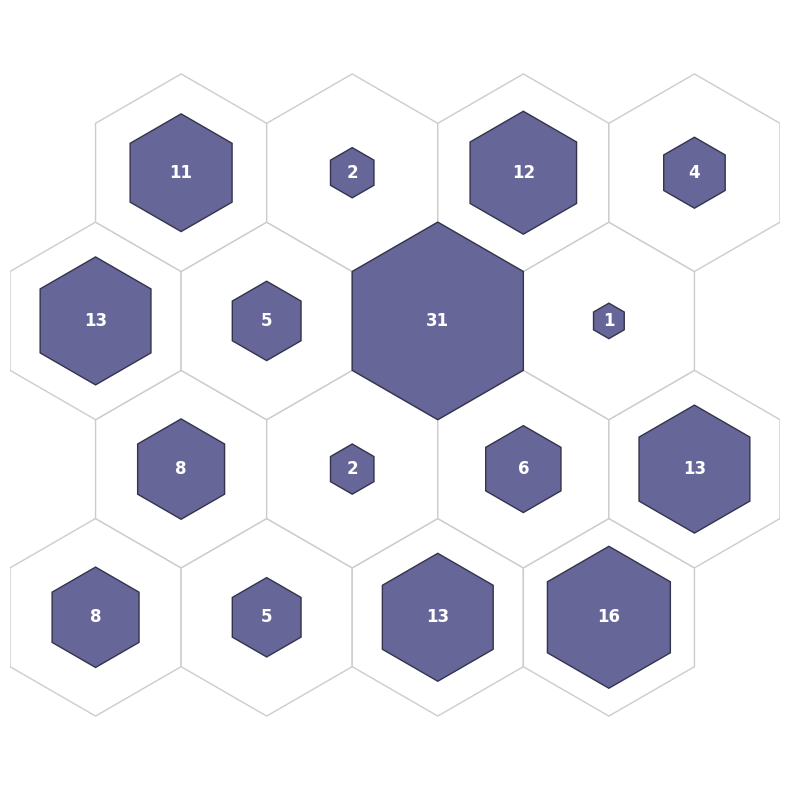

In [32]:
# Plot distances between clusters
fig2, ax2, patch2 = som.neuron_dist_plot()
plt.title('SOM Neighbor Weight Distances', fontsize=16)
plt.show()

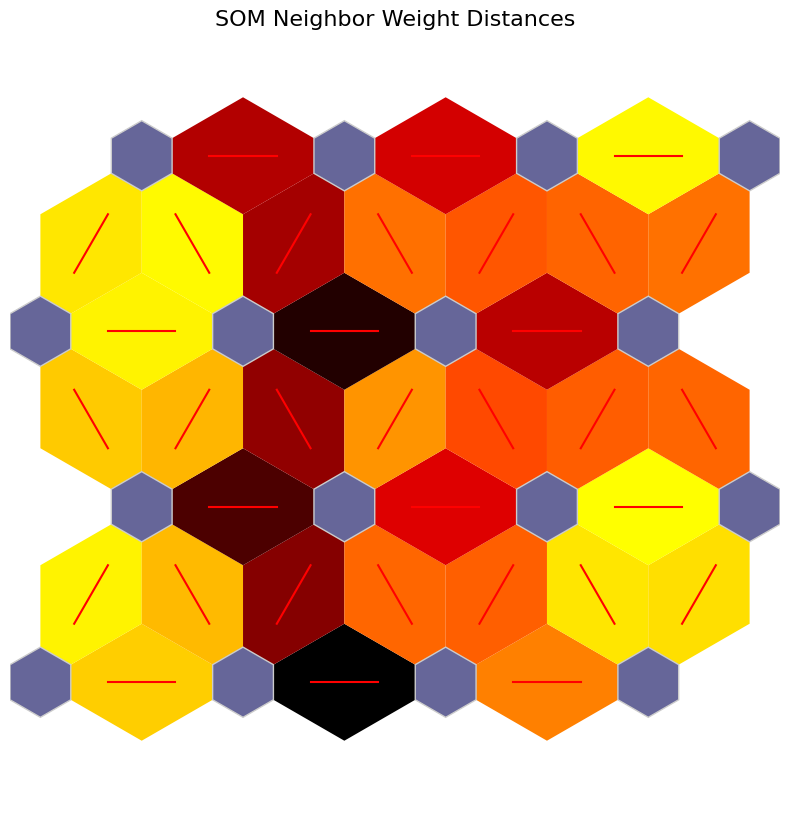

In [33]:
# Plot the topology
fig1, ax1, patch1, text1 = som.plt_top_num()
plt.title('SOM Topology')
plt.show()

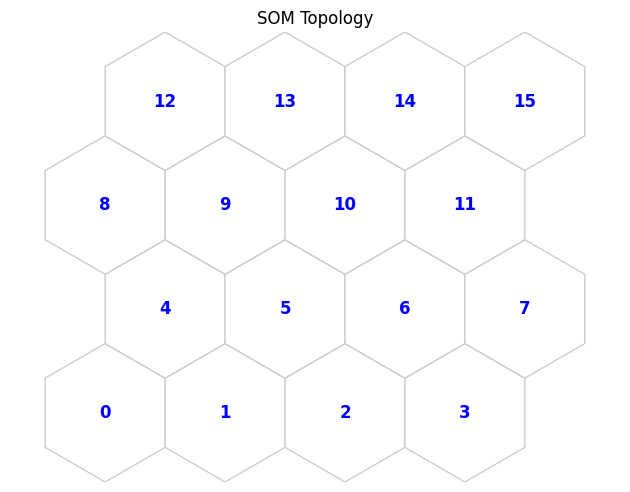

In [34]:
fig3, ax3, patches3, cbar3 = som.simple_grid(mdist, net_ones)
plt.title("Maximum radius for each cluster", fontsize=16)
plt.show()

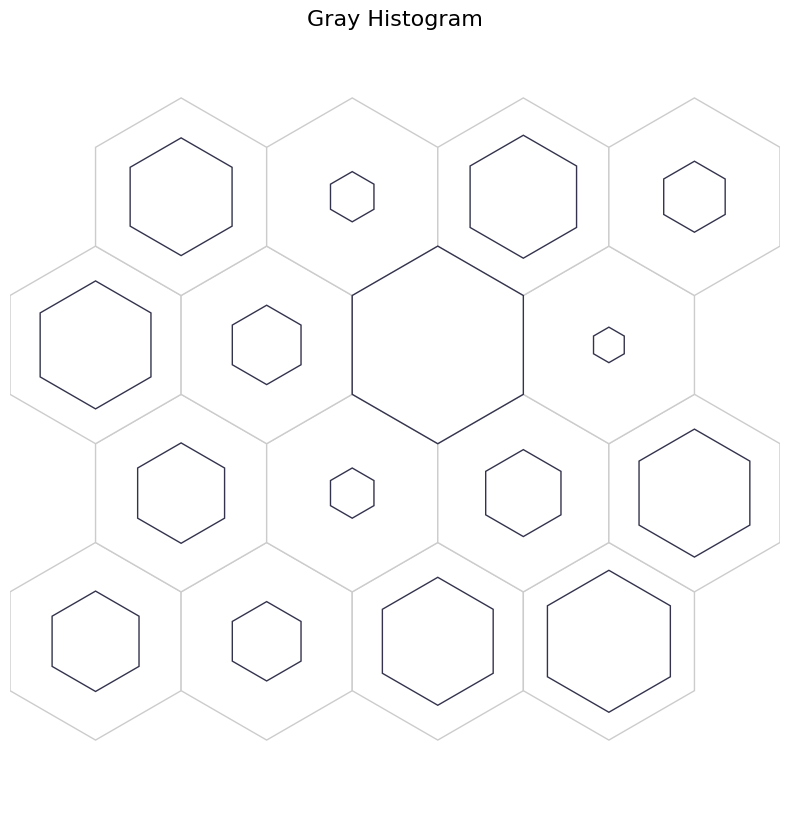